# Building an RL Agent to manage social media accounts on the web

In [ ]:
!wget -q --show-progress https://github.com/RecoHut-Projects/drl-recsys/raw/S990517/tools/webgym.zip
!unzip webgym.zip

In [ ]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [ ]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [ ]:
import webgym

In [ ]:
import argparse
import os
import copy
import random
from collections import deque
from datetime import datetime

import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    Lambda,
    MaxPool2D,
    concatenate,
)

In [ ]:
%load_ext tensorboard

In [ ]:
tf.keras.backend.set_floatx("float64")

## Social Media Like Reply Agent

In [ ]:
parser = argparse.ArgumentParser(prog="TFRL-SocialMedia-Like-Reply-Agent")
parser.add_argument("--env", default="MiniWoBSocialMediaReplyVisualEnv-v0")
parser.add_argument("--update-freq", type=int, default=16)
parser.add_argument("--epochs", type=int, default=3)
parser.add_argument("--actor-lr", type=float, default=1e-4)
parser.add_argument("--critic-lr", type=float, default=1e-4)
parser.add_argument("--clip-ratio", type=float, default=0.1)
parser.add_argument("--gae-lambda", type=float, default=0.95)
parser.add_argument("--gamma", type=float, default=0.99)
parser.add_argument("--logdir", default="logs")

args = parser.parse_args([])
logdir = os.path.join(
    args.logdir, parser.prog, args.env, datetime.now().strftime("%Y%m%d-%H%M%S")
)
print(f"Saving training logs to:{logdir}")
writer = tf.summary.create_file_writer(logdir)

Saving training logs to:logs/TFRL-SocialMedia-Like-Reply-Agent/MiniWoBSocialMediaReplyVisualEnv-v0/20211203-061930


In [ ]:
class Actor:
    def __init__(self, state_dim, action_dim, action_bound, std_bound):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = np.array(action_bound)
        self.std_bound = std_bound
        self.weight_initializer = tf.keras.initializers.he_normal()
        self.eps = 1e-5
        self.model = self.nn_model()
        self.model.summary()  # Print a summary of the Actor model
        self.opt = tf.keras.optimizers.Nadam(args.actor_lr)

    def nn_model(self):
        obs_input = Input(self.state_dim, name="im_obs")
        conv1 = Conv2D(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            input_shape=self.state_dim,
            data_format="channels_last",
            activation="relu",
        )(obs_input)
        pool1 = MaxPool2D(pool_size=(3, 3), strides=1)(conv1)
        conv2 = Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool1)
        pool2 = MaxPool2D(pool_size=(3, 3), strides=1)(conv2)
        conv3 = Conv2D(
            filters=16,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool2)
        pool3 = MaxPool2D(pool_size=(3, 3), strides=1)(conv3)
        conv4 = Conv2D(
            filters=8,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool3)
        pool4 = MaxPool2D(pool_size=(3, 3), strides=1)(conv4)
        flat = Flatten()(pool4)
        dense1 = Dense(
            16, activation="relu", kernel_initializer=self.weight_initializer
        )(flat)
        dropout1 = Dropout(0.3)(dense1)
        dense2 = Dense(
            8, activation="relu", kernel_initializer=self.weight_initializer
        )(dropout1)
        dropout2 = Dropout(0.3)(dense2)
        # action_dim[0] = 2
        output_val = Dense(
            self.action_dim[0],
            activation="relu",
            kernel_initializer=self.weight_initializer,
        )(dropout2)
        # Scale & clip x[i] to be in range [0, action_bound[i]]
        action_bound = copy.deepcopy(self.action_bound)
        mu_output = Lambda(
            lambda x: tf.clip_by_value(x * action_bound, 1e-9, action_bound),
            name="mu_output",
        )(output_val)
        std_output_1 = Dense(
            self.action_dim[0],
            activation="softplus",
            kernel_initializer=self.weight_initializer,
        )(dropout2)
        std_output = Lambda(
            lambda x: tf.clip_by_value(
                x * action_bound, 1e-9, action_bound / 2, name="std_output"
            )
        )(std_output_1)
        return tf.keras.models.Model(
            inputs=obs_input, outputs=[mu_output, std_output], name="Actor"
        )

    def get_action(self, state):
        # Convert [Image] to np.array(np.adarray)
        state_np = np.array([np.array(s) for s in state])
        if len(state_np.shape) == 3:
            # Convert (w, h, c) to (1, w, h, c)
            state_np = np.expand_dims(state_np, 0)
        mu, std = self.model.predict(state_np)
        action = np.random.normal(mu[0], std[0] + self.eps, size=self.action_dim).astype(
            "int"
        )
        # Clip action to be between 0 and max obs screen size
        action = np.clip(action, 0, self.action_bound)
        # 1 Action per instance of env; Env expects: (num_instances, actions)
        action = (action,)
        log_policy = self.log_pdf(mu, std, action)
        return log_policy, action

    def log_pdf(self, mu, std, action):
        std = tf.clip_by_value(std, self.std_bound[0], self.std_bound[1])
        var = std ** 2
        log_policy_pdf = -0.5 * (action - mu) ** 2 / var - 0.5 * tf.math.log(
            var * 2 * np.pi
        )
        return tf.reduce_sum(log_policy_pdf, 1, keepdims=True)

    def compute_loss(self, log_old_policy, log_new_policy, actions, gaes):
        # Avoid INF in exp by setting 80 as the upper bound since,
        # tf.exp(x) for x>88 yeilds NaN (float32)
        ratio = tf.exp(
            tf.minimum(log_new_policy - tf.stop_gradient(log_old_policy), 80)
        )
        gaes = tf.stop_gradient(gaes)
        clipped_ratio = tf.clip_by_value(
            ratio, 1.0 - args.clip_ratio, 1.0 + args.clip_ratio
        )
        surrogate = -tf.minimum(ratio * gaes, clipped_ratio * gaes)
        return tf.reduce_mean(surrogate)

    def train(self, log_old_policy, states, actions, gaes):
        with tf.GradientTape() as tape:
            mu, std = self.model(states, training=True)
            log_new_policy = self.log_pdf(mu, std, actions)
            loss = self.compute_loss(log_old_policy, log_new_policy, actions, gaes)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def save(self, model_dir: str, version: int = 1):
        actor_model_save_dir = os.path.join(
            model_dir, "actor", str(version), "model.savedmodel"
        )
        self.model.save(actor_model_save_dir, save_format="tf")
        print(f"Actor model saved at:{actor_model_save_dir}")


class Critic:
    def __init__(self, state_dim):
        self.state_dim = state_dim
        self.weight_initializer = tf.keras.initializers.he_normal()
        self.model = self.nn_model()
        self.model.summary()  # Print a summary of the Critic model
        self.opt = tf.keras.optimizers.Nadam(args.critic_lr)

    def nn_model(self):
        obs_input = Input(self.state_dim)
        conv1 = Conv2D(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            input_shape=self.state_dim,
            data_format="channels_last",
            activation="relu",
        )(obs_input)
        pool1 = MaxPool2D(pool_size=(3, 3), strides=2)(conv1)
        conv2 = Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool1)
        pool2 = MaxPool2D(pool_size=(3, 3), strides=2)(conv2)
        conv3 = Conv2D(
            filters=16,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool2)
        pool3 = MaxPool2D(pool_size=(3, 3), strides=1)(conv3)
        conv4 = Conv2D(
            filters=8,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool3)
        pool4 = MaxPool2D(pool_size=(3, 3), strides=1)(conv4)
        flat = Flatten()(pool4)
        dense1 = Dense(
            16, activation="relu", kernel_initializer=self.weight_initializer
        )(flat)
        dropout1 = Dropout(0.3)(dense1)
        dense2 = Dense(
            8, activation="relu", kernel_initializer=self.weight_initializer
        )(dropout1)
        dropout2 = Dropout(0.3)(dense2)
        value = Dense(
            1, activation="linear", kernel_initializer=self.weight_initializer
        )(dropout2)

        return tf.keras.models.Model(inputs=obs_input, outputs=value, name="Critic")

    def compute_loss(self, v_pred, td_targets):
        mse = tf.keras.losses.MeanSquaredError()
        return mse(td_targets, v_pred)

    def train(self, states, td_targets):
        with tf.GradientTape() as tape:
            v_pred = self.model(states, training=True)
            # assert v_pred.shape == td_targets.shape
            loss = self.compute_loss(v_pred, tf.stop_gradient(td_targets))
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def save(self, model_dir: str, version: int = 1):
        critic_model_save_dir = os.path.join(
            model_dir, "critic", str(version), "model.savedmodel"
        )
        self.model.save(critic_model_save_dir, save_format="tf")
        print(f"Critic model saved at:{critic_model_save_dir}")


class PPOAgent:
    def __init__(self, env):
        self.env = env
        self.state_dim = self.env.observation_space.shape
        self.action_dim = self.env.action_space.shape
        # Set action_bounds to be within the actual task-window/browser-view of the agent
        self.action_bound = [self.env.task_width, self.env.task_height]
        self.std_bound = [1e-2, 1.0]

        self.actor = Actor(
            self.state_dim, self.action_dim, self.action_bound, self.std_bound
        )
        self.critic = Critic(self.state_dim)

    def gae_target(self, rewards, v_values, next_v_value, done):
        n_step_targets = np.zeros_like(rewards)
        gae = np.zeros_like(rewards)
        gae_cumulative = 0
        forward_val = 0

        if not done:
            forward_val = next_v_value

        for k in reversed(range(0, len(rewards))):
            delta = rewards[k] + args.gamma * forward_val - v_values[k]
            gae_cumulative = args.gamma * args.gae_lambda * gae_cumulative + delta
            gae[k] = gae_cumulative
            forward_val = v_values[k]
            n_step_targets[k] = gae[k] + v_values[k]
        return gae, n_step_targets

    def train(self, max_episodes=1000):
        with writer.as_default():
            for ep in range(max_episodes):
                state_batch = []
                action_batch = []
                reward_batch = []
                old_policy_batch = []

                episode_reward, done = 0, False

                state = self.env.reset()
                prev_state = state
                step_num = 0

                while not done:
                    # self.env.render()
                    log_old_policy, action = self.actor.get_action(state)

                    next_state, reward, dones, _ = self.env.step(action)
                    step_num += 1
                    print(
                        f"ep#:{ep} step#:{step_num} step_rew:{reward} action:{action} dones:{dones}"
                    )
                    done = np.all(dones)
                    if done:
                        next_state = prev_state
                    else:
                        prev_state = next_state
                    state = np.array([np.array(s) for s in state])
                    next_state = np.array([np.array(s) for s in next_state])
                    reward = np.reshape(reward, [1, 1])
                    log_old_policy = np.reshape(log_old_policy, [1, 1])

                    state_batch.append(state)
                    action_batch.append(action)
                    reward_batch.append((reward + 8) / 8)
                    old_policy_batch.append(log_old_policy)

                    if len(state_batch) >= args.update_freq or done:
                        states = np.array([state.squeeze() for state in state_batch])
                        # Convert ([x, y],) to [x, y]
                        actions = np.array([action[0] for action in action_batch])
                        rewards = np.array(
                            [reward.squeeze() for reward in reward_batch]
                        )
                        old_policies = np.array(
                            [old_pi.squeeze() for old_pi in old_policy_batch]
                        )

                        v_values = self.critic.model.predict(states)
                        next_v_value = self.critic.model.predict(next_state)

                        gaes, td_targets = self.gae_target(
                            rewards, v_values, next_v_value, done
                        )
                        actor_losses, critic_losses = [], []
                        for epoch in range(args.epochs):
                            actor_loss = self.actor.train(
                                old_policies, states, actions, gaes
                            )
                            actor_losses.append(actor_loss)
                            critic_loss = self.critic.train(states, td_targets)
                            critic_losses.append(critic_loss)
                        # Plot mean actor & critic losses on every update
                        tf.summary.scalar("actor_loss", np.mean(actor_losses), step=ep)
                        tf.summary.scalar(
                            "critic_loss", np.mean(critic_losses), step=ep
                        )

                        state_batch = []
                        action_batch = []
                        reward_batch = []
                        old_policy_batch = []

                    episode_reward += reward[0][0]
                    state = next_state[0]

                print(f"Episode#{ep} Reward:{episode_reward} Actions:{action_batch}")
                tf.summary.scalar("episode_reward", episode_reward, step=ep)

    def save(self, model_dir: str, version: int = 1):
        self.actor.save(model_dir, version)
        self.critic.save(model_dir, version)


if __name__ == "__main__":
    env_name = args.env
    env = gym.make(env_name)
    cta_agent = PPOAgent(env)
    cta_agent.train(max_episodes=2)
    # Model saving
    model_dir = "trained_models"
    agent_name = f"PPO_{env_name}-v0"
    agent_version = 1
    agent_model_path = os.path.join(model_dir, agent_name)
    cta_agent.save(agent_model_path, agent_version)

Model: "Actor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 im_obs (InputLayer)            [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 64, 64, 64)   1792        ['im_obs[0][0]']                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 62, 62, 64)  0           ['conv2d_4[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 60, 60, 32)   18464       ['max_pooling2d_4[0][0]']        
                                                                                              

ep#:0 step#:33 step_rew:[-1.0] action:(array([ 68, 205]),) dones:[True]
Episode#0 Reward:-1.0 Actions:[]
ep#:1 step#:1 step_rew:[0.0] action:(array([160, 197]),) dones:[False]
ep#:1 step#:2 step_rew:[0.0] action:(array([160, 196]),) dones:[False]
ep#:1 step#:3 step_rew:[0.0] action:(array([160, 201]),) dones:[False]
ep#:1 step#:4 step_rew:[0.0] action:(array([160, 210]),) dones:[False]
ep#:1 step#:5 step_rew:[0.0] action:(array([160, 210]),) dones:[False]
ep#:1 step#:6 step_rew:[0.0] action:(array([160, 192]),) dones:[False]
ep#:1 step#:7 step_rew:[0.0] action:(array([160, 203]),) dones:[False]
ep#:1 step#:8 step_rew:[0.0] action:(array([160, 205]),) dones:[False]
ep#:1 step#:9 step_rew:[0.0] action:(array([ 43, 210]),) dones:[False]
ep#:1 step#:10 step_rew:[0.0] action:(array([160, 210]),) dones:[False]
ep#:1 step#:11 step_rew:[0.0] action:(array([160, 210]),) dones:[False]
ep#:1 step#:12 step_rew:[0.0] action:(array([160, 210]),) dones:[False]
ep#:1 step#:13 step_rew:[0.0] action:(ar

ep#:1 step#:33 step_rew:[-1.0] action:(array([160, 202]),) dones:[True]
Episode#1 Reward:-1.0 Actions:[]


INFO:tensorflow:Assets written to: trained_models/PPO_MiniWoBSocialMediaReplyVisualEnv-v0-v0/actor/1/model.savedmodel/assets


INFO:tensorflow:Assets written to: trained_models/PPO_MiniWoBSocialMediaReplyVisualEnv-v0-v0/actor/1/model.savedmodel/assets


Actor model saved at:trained_models/PPO_MiniWoBSocialMediaReplyVisualEnv-v0-v0/actor/1/model.savedmodel


INFO:tensorflow:Assets written to: trained_models/PPO_MiniWoBSocialMediaReplyVisualEnv-v0-v0/critic/1/model.savedmodel/assets


INFO:tensorflow:Assets written to: trained_models/PPO_MiniWoBSocialMediaReplyVisualEnv-v0-v0/critic/1/model.savedmodel/assets


Critic model saved at:trained_models/PPO_MiniWoBSocialMediaReplyVisualEnv-v0-v0/critic/1/model.savedmodel


In [ ]:
%tensorboard --logdir /content/logs/TFRL-SocialMedia-Like-Reply-Agent/MiniWoBSocialMediaReplyVisualEnv-v0

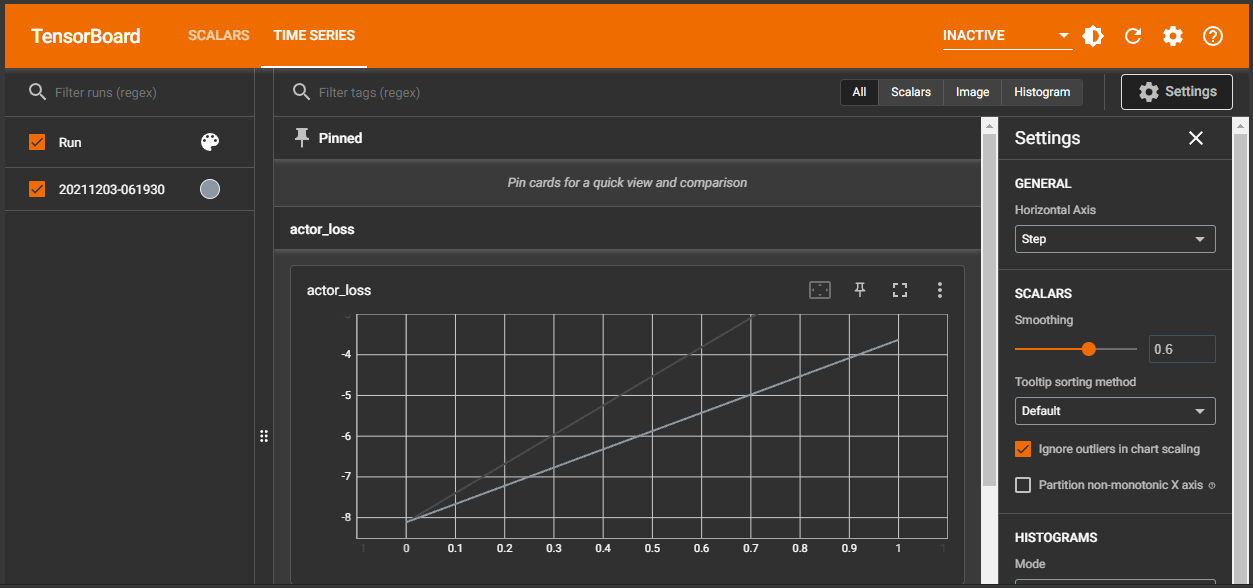

## Social Media Mute Agent

In [ ]:
parser = argparse.ArgumentParser(prog="TFRL-SocialMedia-Mute-User-Agent")
parser.add_argument("--env", default="MiniWoBSocialMediaMuteUserVisualEnv-v0")
parser.add_argument("--update-freq", type=int, default=16)
parser.add_argument("--epochs", type=int, default=3)
parser.add_argument("--actor-lr", type=float, default=1e-4)
parser.add_argument("--critic-lr", type=float, default=1e-4)
parser.add_argument("--clip-ratio", type=float, default=0.1)
parser.add_argument("--gae-lambda", type=float, default=0.95)
parser.add_argument("--gamma", type=float, default=0.99)
parser.add_argument("--logdir", default="logs")

args = parser.parse_args([])
logdir = os.path.join(
    args.logdir, parser.prog, args.env, datetime.now().strftime("%Y%m%d-%H%M%S")
)
print(f"Saving training logs to:{logdir}")
writer = tf.summary.create_file_writer(logdir)

Saving training logs to:logs/TFRL-SocialMedia-Mute-User-Agent/MiniWoBSocialMediaMuteUserVisualEnv-v0/20211203-062327


In [ ]:
class Actor:
    def __init__(self, state_dim, action_dim, action_bound, std_bound):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = np.array(action_bound)
        self.std_bound = std_bound
        self.weight_initializer = tf.keras.initializers.he_normal()
        self.eps = 1e-5
        self.model = self.nn_model()
        self.model.summary()  # Print a summary of the Actor model
        self.opt = tf.keras.optimizers.Nadam(args.actor_lr)

    def nn_model(self):
        obs_input = Input(self.state_dim, name="im_obs")
        conv1 = Conv2D(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            input_shape=self.state_dim,
            data_format="channels_last",
            activation="relu",
        )(obs_input)
        pool1 = MaxPool2D(pool_size=(3, 3), strides=1)(conv1)
        conv2 = Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool1)
        pool2 = MaxPool2D(pool_size=(3, 3), strides=1)(conv2)
        conv3 = Conv2D(
            filters=16,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool2)
        pool3 = MaxPool2D(pool_size=(3, 3), strides=1)(conv3)
        conv4 = Conv2D(
            filters=8,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool3)
        pool4 = MaxPool2D(pool_size=(3, 3), strides=1)(conv4)
        flat = Flatten()(pool4)
        dense1 = Dense(
            16, activation="relu", kernel_initializer=self.weight_initializer
        )(flat)
        dropout1 = Dropout(0.3)(dense1)
        dense2 = Dense(
            8, activation="relu", kernel_initializer=self.weight_initializer
        )(dropout1)
        dropout2 = Dropout(0.3)(dense2)
        # action_dim[0] = 2
        output_val = Dense(
            self.action_dim[0],
            activation="relu",
            kernel_initializer=self.weight_initializer,
        )(dropout2)
        # Scale & clip x[i] to be in range [0, action_bound[i]]
        action_bound = copy.deepcopy(self.action_bound)
        mu_output = Lambda(
            lambda x: tf.clip_by_value(x * action_bound, 1e-9, action_bound),
            name="mu_output",
        )(output_val)
        std_output_1 = Dense(
            self.action_dim[0],
            activation="softplus",
            kernel_initializer=self.weight_initializer,
        )(dropout2)
        std_output = Lambda(
            lambda x: tf.clip_by_value(
                x * action_bound, 1e-9, action_bound / 2, name="std_output"
            )
        )(std_output_1)
        return tf.keras.models.Model(
            inputs=obs_input, outputs=[mu_output, std_output], name="Actor"
        )

    def get_action(self, state):
        # Convert [Image] to np.array(np.adarray)
        state_np = np.array([np.array(s) for s in state])
        if len(state_np.shape) == 3:
            # Convert (w, h, c) to (1, w, h, c)
            state_np = np.expand_dims(state_np, 0)
        mu, std = self.model.predict(state_np)
        action = np.random.normal(mu[0], std[0] + self.eps, size=self.action_dim).astype(
            "int"
        )
        # Clip action to be between 0 and max obs screen size
        action = np.clip(action, 0, self.action_bound)
        # 1 Action per instance of env; Env expects: (num_instances, actions)
        action = (action,)
        log_policy = self.log_pdf(mu, std, action)
        return log_policy, action

    def log_pdf(self, mu, std, action):
        std = tf.clip_by_value(std, self.std_bound[0], self.std_bound[1])
        var = std ** 2
        log_policy_pdf = -0.5 * (action - mu) ** 2 / var - 0.5 * tf.math.log(
            var * 2 * np.pi
        )
        return tf.reduce_sum(log_policy_pdf, 1, keepdims=True)

    def compute_loss(self, log_old_policy, log_new_policy, actions, gaes):
        # Avoid INF in exp by setting 80 as the upper bound since,
        # tf.exp(x) for x>88 yeilds NaN (float32)
        ratio = tf.exp(
            tf.minimum(log_new_policy - tf.stop_gradient(log_old_policy), 80)
        )
        gaes = tf.stop_gradient(gaes)
        clipped_ratio = tf.clip_by_value(
            ratio, 1.0 - args.clip_ratio, 1.0 + args.clip_ratio
        )
        surrogate = -tf.minimum(ratio * gaes, clipped_ratio * gaes)
        return tf.reduce_mean(surrogate)

    def train(self, log_old_policy, states, actions, gaes):
        with tf.GradientTape() as tape:
            mu, std = self.model(states, training=True)
            log_new_policy = self.log_pdf(mu, std, actions)
            loss = self.compute_loss(log_old_policy, log_new_policy, actions, gaes)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def save(self, model_dir: str, version: int = 1):
        actor_model_save_dir = os.path.join(
            model_dir, "actor", str(version), "model.savedmodel"
        )
        self.model.save(actor_model_save_dir, save_format="tf")
        print(f"Actor model saved at:{actor_model_save_dir}")


class Critic:
    def __init__(self, state_dim):
        self.state_dim = state_dim
        self.weight_initializer = tf.keras.initializers.he_normal()
        self.model = self.nn_model()
        self.model.summary()  # Print a summary of the Critic model
        self.opt = tf.keras.optimizers.Nadam(args.critic_lr)

    def nn_model(self):
        obs_input = Input(self.state_dim)
        conv1 = Conv2D(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            input_shape=self.state_dim,
            data_format="channels_last",
            activation="relu",
        )(obs_input)
        pool1 = MaxPool2D(pool_size=(3, 3), strides=2)(conv1)
        conv2 = Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool1)
        pool2 = MaxPool2D(pool_size=(3, 3), strides=2)(conv2)
        conv3 = Conv2D(
            filters=16,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool2)
        pool3 = MaxPool2D(pool_size=(3, 3), strides=1)(conv3)
        conv4 = Conv2D(
            filters=8,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool3)
        pool4 = MaxPool2D(pool_size=(3, 3), strides=1)(conv4)
        flat = Flatten()(pool4)
        dense1 = Dense(
            16, activation="relu", kernel_initializer=self.weight_initializer
        )(flat)
        dropout1 = Dropout(0.3)(dense1)
        dense2 = Dense(
            8, activation="relu", kernel_initializer=self.weight_initializer
        )(dropout1)
        dropout2 = Dropout(0.3)(dense2)
        value = Dense(
            1, activation="linear", kernel_initializer=self.weight_initializer
        )(dropout2)

        return tf.keras.models.Model(inputs=obs_input, outputs=value, name="Critic")

    def compute_loss(self, v_pred, td_targets):
        mse = tf.keras.losses.MeanSquaredError()
        return mse(td_targets, v_pred)

    def train(self, states, td_targets):
        with tf.GradientTape() as tape:
            v_pred = self.model(states, training=True)
            # assert v_pred.shape == td_targets.shape
            loss = self.compute_loss(v_pred, tf.stop_gradient(td_targets))
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss

    def save(self, model_dir: str, version: int = 1):
        critic_model_save_dir = os.path.join(
            model_dir, "critic", str(version), "model.savedmodel"
        )
        self.model.save(critic_model_save_dir, save_format="tf")
        print(f"Critic model saved at:{critic_model_save_dir}")


class PPOAgent:
    def __init__(self, env):
        self.env = env
        self.state_dim = self.env.observation_space.shape
        self.action_dim = self.env.action_space.shape
        # Set action_bounds to be within the actual task-window/browser-view of the agent
        self.action_bound = [self.env.task_width, self.env.task_height]
        self.std_bound = [1e-2, 1.0]

        self.actor = Actor(
            self.state_dim, self.action_dim, self.action_bound, self.std_bound
        )
        self.critic = Critic(self.state_dim)

    def gae_target(self, rewards, v_values, next_v_value, done):
        n_step_targets = np.zeros_like(rewards)
        gae = np.zeros_like(rewards)
        gae_cumulative = 0
        forward_val = 0

        if not done:
            forward_val = next_v_value

        for k in reversed(range(0, len(rewards))):
            delta = rewards[k] + args.gamma * forward_val - v_values[k]
            gae_cumulative = args.gamma * args.gae_lambda * gae_cumulative + delta
            gae[k] = gae_cumulative
            forward_val = v_values[k]
            n_step_targets[k] = gae[k] + v_values[k]
        return gae, n_step_targets

    def train(self, max_episodes=1000):
        with writer.as_default():
            for ep in range(max_episodes):
                state_batch = []
                action_batch = []
                reward_batch = []
                old_policy_batch = []

                episode_reward, done = 0, False

                state = self.env.reset()
                prev_state = state
                step_num = 0

                while not done:
                    # self.env.render()
                    log_old_policy, action = self.actor.get_action(state)

                    next_state, reward, dones, _ = self.env.step(action)
                    step_num += 1
                    print(
                        f"ep#:{ep} step#:{step_num} step_rew:{reward} action:{action} dones:{dones}"
                    )
                    done = np.all(dones)
                    if done:
                        next_state = prev_state
                    else:
                        prev_state = next_state
                    state = np.array([np.array(s) for s in state])
                    next_state = np.array([np.array(s) for s in next_state])
                    reward = np.reshape(reward, [1, 1])
                    log_old_policy = np.reshape(log_old_policy, [1, 1])

                    state_batch.append(state)
                    action_batch.append(action)
                    reward_batch.append((reward + 8) / 8)
                    old_policy_batch.append(log_old_policy)

                    if len(state_batch) >= args.update_freq or done:
                        states = np.array([state.squeeze() for state in state_batch])
                        # Convert ([x, y],) to [x, y]
                        actions = np.array([action[0] for action in action_batch])
                        rewards = np.array(
                            [reward.squeeze() for reward in reward_batch]
                        )
                        old_policies = np.array(
                            [old_pi.squeeze() for old_pi in old_policy_batch]
                        )

                        v_values = self.critic.model.predict(states)
                        next_v_value = self.critic.model.predict(next_state)

                        gaes, td_targets = self.gae_target(
                            rewards, v_values, next_v_value, done
                        )
                        actor_losses, critic_losses = [], []
                        for epoch in range(args.epochs):
                            actor_loss = self.actor.train(
                                old_policies, states, actions, gaes
                            )
                            actor_losses.append(actor_loss)
                            critic_loss = self.critic.train(states, td_targets)
                            critic_losses.append(critic_loss)
                        # Plot mean actor & critic losses on every update
                        tf.summary.scalar("actor_loss", np.mean(actor_losses), step=ep)
                        tf.summary.scalar(
                            "critic_loss", np.mean(critic_losses), step=ep
                        )

                        state_batch = []
                        action_batch = []
                        reward_batch = []
                        old_policy_batch = []

                    episode_reward += reward[0][0]
                    state = next_state[0]

                print(f"Episode#{ep} Reward:{episode_reward} Actions:{action_batch}")
                tf.summary.scalar("episode_reward", episode_reward, step=ep)

    def save(self, model_dir: str, version: int = 1):
        self.actor.save(model_dir, version)
        self.critic.save(model_dir, version)


if __name__ == "__main__":
    env_name = args.env
    env = gym.make(env_name)
    cta_agent = PPOAgent(env)
    cta_agent.train(max_episodes=2)
    # Model saving
    model_dir = "trained_models"
    agent_name = f"PPO_{env_name}"
    agent_version = 1
    agent_model_path = os.path.join(model_dir, agent_name)
    cta_agent.save(agent_model_path, agent_version)

Model: "Actor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 im_obs (InputLayer)            [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 64, 64, 64)   1792        ['im_obs[0][0]']                 
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 62, 62, 64)  0           ['conv2d_20[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 60, 60, 32)   18464       ['max_pooling2d_20[0][0]']   

ep#:0 step#:26 step_rew:[0.0] action:(array([80, 81]),) dones:[False]
ep#:0 step#:27 step_rew:[-1.0] action:(array([ 0, 14]),) dones:[True]
Episode#0 Reward:-1.0 Actions:[]
ep#:1 step#:1 step_rew:[0.0] action:(array([ 0, 48]),) dones:[False]
ep#:1 step#:2 step_rew:[0.0] action:(array([60, 83]),) dones:[False]
ep#:1 step#:3 step_rew:[0.0] action:(array([95,  0]),) dones:[False]
ep#:1 step#:4 step_rew:[0.0] action:(array([  0, 184]),) dones:[False]
ep#:1 step#:5 step_rew:[0.0] action:(array([0, 4]),) dones:[False]
ep#:1 step#:6 step_rew:[0.0] action:(array([0, 0]),) dones:[False]
ep#:1 step#:7 step_rew:[0.0] action:(array([160,   0]),) dones:[False]
ep#:1 step#:8 step_rew:[0.0] action:(array([0, 0]),) dones:[False]
ep#:1 step#:9 step_rew:[0.0] action:(array([29, 43]),) dones:[False]
ep#:1 step#:10 step_rew:[0.0] action:(array([ 0, 81]),) dones:[False]
ep#:1 step#:11 step_rew:[0.0] action:(array([65,  0]),) dones:[False]
ep#:1 step#:12 step_rew:[0.0] action:(array([0, 0]),) dones:[False]


ep#:1 step#:27 step_rew:[0.0] action:(array([  0, 172]),) dones:[False]
ep#:1 step#:28 step_rew:[-1.0] action:(array([  0, 140]),) dones:[True]
Episode#1 Reward:-1.0 Actions:[]


INFO:tensorflow:Assets written to: trained_models/PPO_MiniWoBSocialMediaMuteUserVisualEnv-v0/actor/1/model.savedmodel/assets


INFO:tensorflow:Assets written to: trained_models/PPO_MiniWoBSocialMediaMuteUserVisualEnv-v0/actor/1/model.savedmodel/assets


Actor model saved at:trained_models/PPO_MiniWoBSocialMediaMuteUserVisualEnv-v0/actor/1/model.savedmodel


INFO:tensorflow:Assets written to: trained_models/PPO_MiniWoBSocialMediaMuteUserVisualEnv-v0/critic/1/model.savedmodel/assets


INFO:tensorflow:Assets written to: trained_models/PPO_MiniWoBSocialMediaMuteUserVisualEnv-v0/critic/1/model.savedmodel/assets


Critic model saved at:trained_models/PPO_MiniWoBSocialMediaMuteUserVisualEnv-v0/critic/1/model.savedmodel


In [ ]:
%tensorboard --logdir /content/logs/TFRL-SocialMedia-Mute-User-Agent/MiniWoBSocialMediaMuteUserVisualEnv-v0

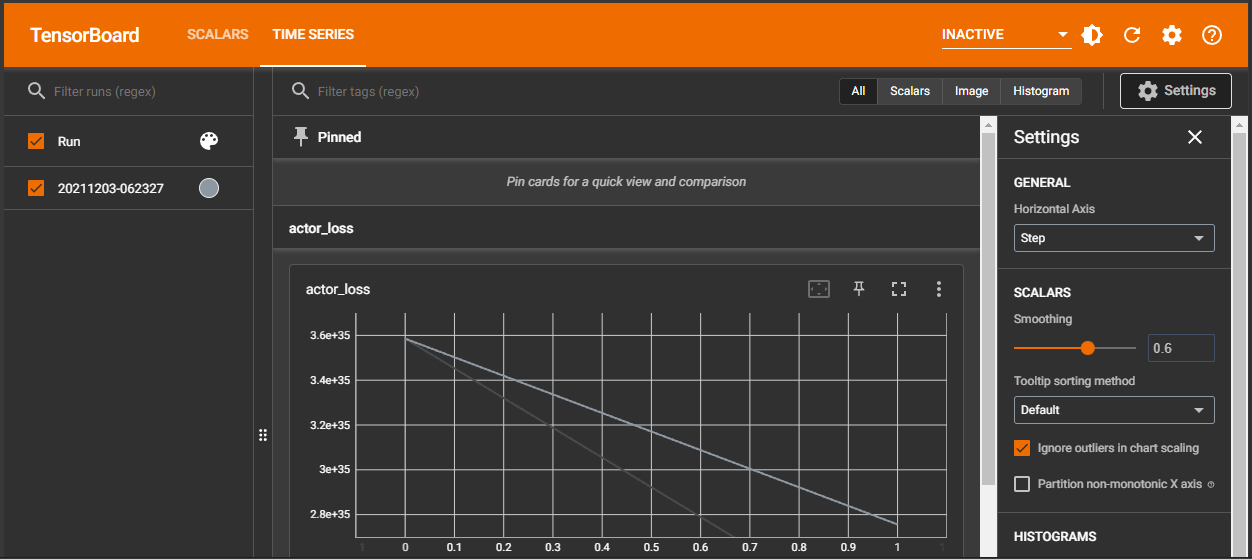

## Social Media Mute Agent DDPG

In [ ]:
parser = argparse.ArgumentParser(
    prog="TFRL-SocialMedia-Mute-User-DDPGAgent"
)
parser.add_argument("--env", default="MiniWoBSocialMediaMuteUserVisualEnv-v0")
parser.add_argument("--actor_lr", type=float, default=0.0005)
parser.add_argument("--critic_lr", type=float, default=0.001)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--tau", type=float, default=0.05)
parser.add_argument("--gamma", type=float, default=0.99)
parser.add_argument("--train_start", type=int, default=2000)
parser.add_argument("--logdir", default="logs")

args = parser.parse_args([])
logdir = os.path.join(
    args.logdir, parser.prog, args.env, datetime.now().strftime("%Y%m%d-%H%M%S")
)
print(f"Saving training logs to:{logdir}")
writer = tf.summary.create_file_writer(logdir)

Saving training logs to:logs/TFRL-SocialMedia-Mute-User-DDPGAgent/MiniWoBSocialMediaMuteUserVisualEnv-v0/20211203-062554


In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append([state, action, reward, next_state, done])

    def sample(self):
        sample = random.sample(self.buffer, args.batch_size)
        states, actions, rewards, next_states, done = map(np.asarray, zip(*sample))
        states = np.array(states).reshape(args.batch_size, -1)
        next_states = np.array(next_states).reshape(args.batch_size, -1)
        return states, actions, rewards, next_states, done

    def size(self):
        return len(self.buffer)


class Actor:
    def __init__(self, state_dim, action_dim, action_bound):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.weight_initializer = tf.keras.initializers.he_normal()
        self.eps = 1e-5
        self.model = self.nn_model()
        self.opt = tf.keras.optimizers.Adam(args.actor_lr)

    def nn_model(self):
        obs_input = Input(self.state_dim)
        conv1 = Conv2D(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            input_shape=self.state_dim,
            data_format="channels_last",
            activation="relu",
        )(obs_input)
        pool1 = MaxPool2D(pool_size=(3, 3), strides=1)(conv1)
        conv2 = Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool1)
        pool2 = MaxPool2D(pool_size=(3, 3), strides=1)(conv2)
        conv3 = Conv2D(
            filters=16,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool2)
        pool3 = MaxPool2D(pool_size=(3, 3), strides=1)(conv3)
        conv4 = Conv2D(
            filters=8,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool3)
        pool4 = MaxPool2D(pool_size=(3, 3), strides=1)(conv4)
        flat = Flatten()(pool4)
        dense1 = Dense(
            16, activation="relu", kernel_initializer=self.weight_initializer
        )(flat)
        dropout1 = Dropout(0.3)(dense1)
        dense2 = Dense(
            8, activation="relu", kernel_initializer=self.weight_initializer
        )(dropout1)
        dropout2 = Dropout(0.3)(dense2)
        # action_dim[0] = 2
        output_val = Dense(
            self.action_dim[0],
            activation="relu",
            kernel_initializer=self.weight_initializer,
        )(dropout2)
        # Scale & clip x[i] to be in range [0, action_bound[i]]
        mu_output = Lambda(
            lambda x: tf.clip_by_value(x * self.action_bound, 1e-9, self.action_bound)
        )(output_val)
        return tf.keras.models.Model(inputs=obs_input, outputs=mu_output, name="Actor")

    def train(self, states, q_grads):
        with tf.GradientTape() as tape:
            grads = tape.gradient(
                self.model(states), self.model.trainable_variables, -q_grads
            )
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))

    def predict(self, state):
        return self.model.predict(state)

    def get_action(self, state):
        # Convert [Image] to np.array(np.adarray)
        state_np = np.array([np.array(s) for s in state])
        if len(state_np.shape) == 3:
            # Convert (w, h, c) to (1, w, h, c)
            state_np = np.expand_dims(state_np, 0)
        action = self.model.predict(state_np)
        # Clip action to be between 0 and max obs screen size
        action = np.clip(action, 0, self.action_bound)
        # 1 Action per instance of env; Env expects: (num_instances, actions)
        return action


class Critic:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.weight_initializer = tf.keras.initializers.he_normal()
        self.model = self.nn_model()
        self.opt = tf.keras.optimizers.Adam(args.critic_lr)

    def nn_model(self):
        obs_input = Input(self.state_dim)
        conv1 = Conv2D(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            input_shape=self.state_dim,
            data_format="channels_last",
            activation="relu",
        )(obs_input)
        pool1 = MaxPool2D(pool_size=(3, 3), strides=2)(conv1)
        conv2 = Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool1)
        pool2 = MaxPool2D(pool_size=(3, 3), strides=2)(conv2)
        conv3 = Conv2D(
            filters=16,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool2)
        pool3 = MaxPool2D(pool_size=(3, 3), strides=1)(conv3)
        conv4 = Conv2D(
            filters=8,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="valid",
            activation="relu",
        )(pool3)
        pool4 = MaxPool2D(pool_size=(3, 3), strides=1)(conv4)
        flat = Flatten()(pool4)
        dense1 = Dense(
            16, activation="relu", kernel_initializer=self.weight_initializer
        )(flat)
        dropout1 = Dropout(0.3)(dense1)
        dense2 = Dense(
            8, activation="relu", kernel_initializer=self.weight_initializer
        )(dropout1)
        dropout2 = Dropout(0.3)(dense2)
        value = Dense(
            1, activation="linear", kernel_initializer=self.weight_initializer
        )(dropout2)

        return tf.keras.models.Model(inputs=obs_input, outputs=value, name="Critic")

    def predict(self, inputs):
        return self.model.predict(inputs)

    def q_gradients(self, states, actions):
        actions = tf.convert_to_tensor(actions)
        with tf.GradientTape() as tape:
            tape.watch(actions)
            q_values = self.model([states, actions])
            q_values = tf.squeeze(q_values)
        return tape.gradient(q_values, actions)

    def compute_loss(self, v_pred, td_targets):
        mse = tf.keras.losses.MeanSquaredError()
        return mse(td_targets, v_pred)

    def train(self, states, actions, td_targets):
        with tf.GradientTape() as tape:
            v_pred = self.model([states, actions], training=True)
            assert v_pred.shape == td_targets.shape
            loss = self.compute_loss(v_pred, tf.stop_gradient(td_targets))
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss


class DDPGAgent:
    def __init__(self, env):
        self.env = env
        self.state_dim = self.env.observation_space.shape
        self.action_dim = self.env.action_space.shape
        self.action_bound = self.env.action_space.high

        self.buffer = ReplayBuffer()

        self.actor = Actor(self.state_dim, self.action_dim, self.action_bound)
        self.critic = Critic(self.state_dim, self.action_dim)

        self.target_actor = Actor(self.state_dim, self.action_dim, self.action_bound)
        self.target_critic = Critic(self.state_dim, self.action_dim)

        actor_weights = self.actor.model.get_weights()
        critic_weights = self.critic.model.get_weights()
        self.target_actor.model.set_weights(actor_weights)
        self.target_critic.model.set_weights(critic_weights)

    def update_target(self):
        actor_weights = self.actor.model.get_weights()
        t_actor_weights = self.target_actor.model.get_weights()
        critic_weights = self.critic.model.get_weights()
        t_critic_weights = self.target_critic.model.get_weights()

        for i in range(len(actor_weights)):
            t_actor_weights[i] = (
                args.tau * actor_weights[i] + (1 - args.tau) * t_actor_weights[i]
            )

        for i in range(len(critic_weights)):
            t_critic_weights[i] = (
                args.tau * critic_weights[i] + (1 - args.tau) * t_critic_weights[i]
            )

        self.target_actor.model.set_weights(t_actor_weights)
        self.target_critic.model.set_weights(t_critic_weights)

    def get_td_target(self, rewards, q_values, dones):
        targets = np.asarray(q_values)
        for i in range(q_values.shape[0]):
            if dones[i]:
                targets[i] = rewards[i]
            else:
                targets[i] = args.gamma * q_values[i]
        return targets

    def add_ou_noise(self, x, rho=0.15, mu=0, dt=1e-1, sigma=0.2, dim=1):
        return (
            x + rho * (mu - x) * dt + sigma * np.sqrt(dt) * np.random.normal(size=dim)
        )

    def replay_experience(self):
        for _ in range(10):
            states, actions, rewards, next_states, dones = self.buffer.sample()
            target_q_values = self.target_critic.predict(
                [next_states, self.target_actor.predict(next_states)]
            )
            td_targets = self.get_td_target(rewards, target_q_values, dones)

            self.critic.train(states, actions, td_targets)

            s_actions = self.actor.predict(states)
            s_grads = self.critic.q_gradients(states, s_actions)
            grads = np.array(s_grads).reshape((-1, self.action_dim))
            self.actor.train(states, grads)
            self.update_target()

    def train(self, max_episodes=1000):
        with writer.as_default():
            for ep in range(max_episodes):
                step_num, episode_reward, done = 0, 0, False

                state = self.env.reset()
                prev_state = state
                bg_noise = np.random.randint(
                    self.env.action_space.low,
                    self.env.action_space.high,
                    self.env.action_space.shape,
                )
                while not done:
                    # self.env.render()
                    action = self.actor.get_action(state)
                    noise = self.add_ou_noise(bg_noise, dim=self.action_dim)
                    action = np.clip(action + noise, 0, self.action_bound).astype("int")

                    next_state, reward, dones, _ = self.env.step(action)
                    done = np.all(dones)
                    if done:
                        next_state = prev_state
                    else:
                        prev_state = next_state

                    for (s, a, r, s_n, d) in zip(
                        next_state, action, reward, next_state, dones
                    ):
                        self.buffer.store(s, a, (r + 8) / 8, s_n, d)
                        episode_reward += r

                    step_num += 1  # 1 across num_instances
                    print(
                        f"ep#:{ep} step#:{step_num} step_rew:{reward} action:{action} dones:{dones}"
                    )

                    bg_noise = noise
                    state = next_state
                if (
                    self.buffer.size() >= args.batch_size
                    and self.buffer.size() >= args.train_start
                ):
                    self.replay_experience()
                print(f"Episode#{ep} Reward:{episode_reward}")
                tf.summary.scalar("episode_reward", episode_reward, step=ep)


if __name__ == "__main__":
    env_name = "MiniWoBSocialMediaMuteUserVisualEnv-v0"
    env = gym.make(env_name)
    agent = DDPGAgent(env)
    agent.train(max_episodes=2)

ep#:0 step#:1 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:0 step#:2 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:0 step#:3 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:0 step#:4 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:0 step#:5 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:0 step#:6 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:0 step#:7 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:0 step#:8 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:0 step#:9 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:0 step#:10 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:0 step#:11 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:0 step#:12 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:0 step#:13 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:0 step#:14 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:0 step#:15 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:0 step#:16 step_rew:[0.0] action:[[160 210]] dones:[False]
e

ep#:0 step#:35 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:0 step#:36 step_rew:[-1.0] action:[[160 210]] dones:[True]
Episode#0 Reward:-1.0
ep#:1 step#:1 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:1 step#:2 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:1 step#:3 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:1 step#:4 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:1 step#:5 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:1 step#:6 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:1 step#:7 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:1 step#:8 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:1 step#:9 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:1 step#:10 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:1 step#:11 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:1 step#:12 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:1 step#:13 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:1 step#:14 step_rew:[0.0] action:[[160

ep#:1 step#:36 step_rew:[0.0] action:[[160 210]] dones:[False]
ep#:1 step#:37 step_rew:[-1.0] action:[[160 210]] dones:[True]
Episode#1 Reward:-1.0


In [ ]:
%tensorboard --logdir /content/logs/TFRL-SocialMedia-Mute-User-DDPGAgent/MiniWoBSocialMediaMuteUserVisualEnv-v0

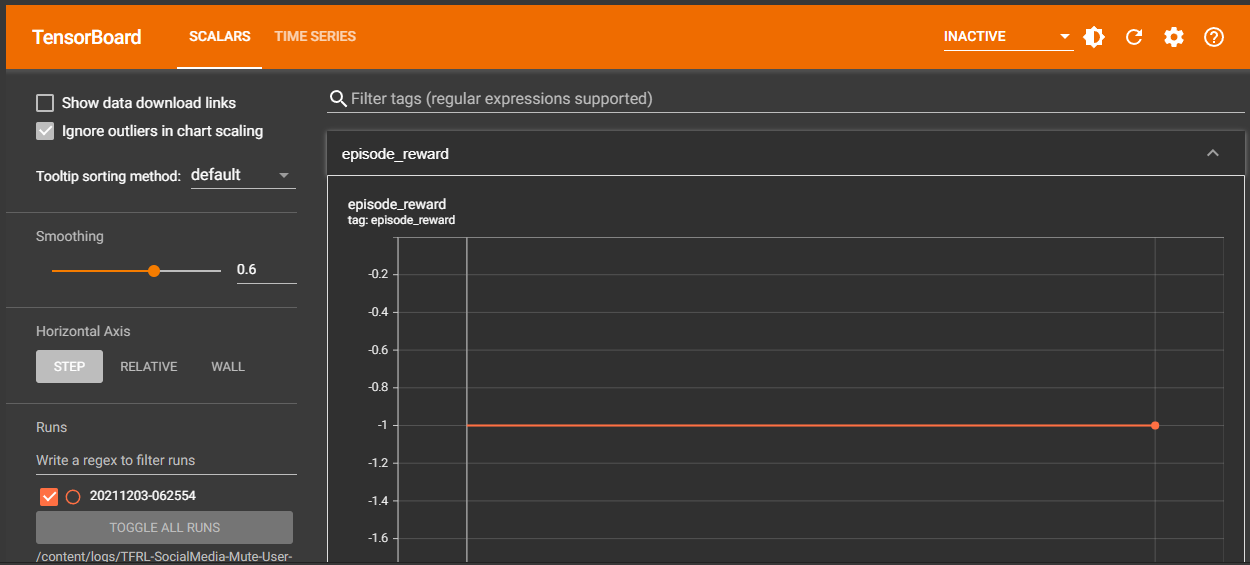

---

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d -p selenium

Author: Sparsh A.

Last updated: 2021-12-03 06:32:29

selenium: 4.1.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

argparse  : 1.1
sys       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
gym       : 0.17.3
tensorflow: 2.7.0
IPython   : 5.5.0
numpy     : 1.19.5



---

**END**